In [1]:
%cd D:\Dropbox (GaTech)\CS7643 Deep Learning\Deep-Shading
%load_ext autoreload
%autoreload 2
from shading_model import *
from data_utils import *
from torch.autograd import Variable

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

device = torch.device("cuda")

D:\Dropbox (GaTech)\CS7643 Deep Learning\Deep-Shading


In [2]:
index_path = "\\Dropbox (GaTech)\\CS7643 Deep Learning\\Deep-Shading\\example_data\\AO\\"
data_path = index_path
trainset = AODataset(index_path, data_path, split="test")
#subset_indices = list(range(1))
#trainset = torch.utils.data.Subset(trainset, subset_indices)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

In [3]:
model = ShadingModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
loss_func = nn.MSELoss()

for epoch in range(20):
    for i, data in enumerate(dataloader, 0):
        pos, normal, gt = data
        pos, normal, gt = Variable(pos).to(device), Variable(normal).to(device), Variable(gt).to(device)
        pos = pos.permute(0, 3, 1, 2)
        normal = normal.permute(0, 3, 1, 2)
        gt = gt.unsqueeze(1)
        optimizer.zero_grad()
        image = torch.cat((gt, gt, gt, normal), 1)
        outputs = model(image)
        loss = model.loss(outputs, gt)
        #loss = loss_func(outputs, gt)
        loss.backward()
        optimizer.step()
    print(epoch, loss.item())

0 0.4598921239376068
1 0.1803322434425354
2 0.207969069480896
3 0.19366836547851562
4 0.14341890811920166
5 0.14828938245773315
6 0.1270003616809845
7 0.11570504307746887
8 0.10661900043487549
9 0.11490470170974731
10 0.10897541046142578
11 0.11103266477584839
12 0.10637697577476501
13 0.10354098677635193
14 0.09763127565383911
15 0.10039779543876648
16 0.10451510548591614
17 0.09904980659484863
18 0.09298351407051086
19 0.09262281656265259


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()
for epoch in range(40):
    for i, data in enumerate(dataloader, 0):
        pos, normal, gt = data
        pos, normal, gt = Variable(pos).to(device), Variable(normal).to(device), Variable(gt).to(device)
        pos = pos.permute(0, 3, 1, 2)
        normal = normal.permute(0, 3, 1, 2)
        gt = gt.unsqueeze(1)
        optimizer.zero_grad()
        image = torch.cat((normal, pos), 1)
        outputs = model(image)
        loss = model.loss(outputs, gt)
        #loss = loss_func(outputs, gt)
        loss.backward()
        optimizer.step()
    print(epoch, loss.item())

0 0.2466106116771698
1 0.225160151720047
2 0.2547335624694824
3 0.23866835236549377
4 0.2229740023612976
5 0.2358292043209076


KeyboardInterrupt: 

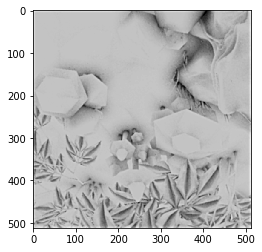

In [4]:
image = torch.cat((gt,gt,gt, pos), 1)
model.eval()
i = model(image)
pic = i.squeeze(1).cpu().data[0].numpy()
plt.imshow(pic, cmap='gray')

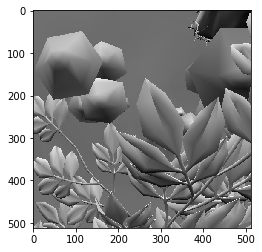

In [13]:
pic = normal[:,1,:,:].cpu().data[0].numpy()
plt.imshow(pic, cmap='gray')

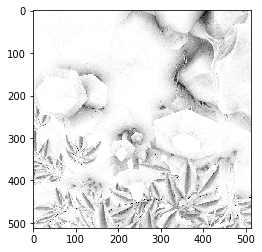

In [5]:
pic = gt.squeeze(1).cpu().data[0].numpy()
plt.imshow(pic, cmap='gray')

In [18]:
pic = exr_loader("./Position/000000000..exr", ndim=3)

D:\WinPython\python-3.6.5.amd64\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [7]:
from torchsummary import summary
print(image.size())
summary(model, (6,512,512))

torch.Size([8, 6, 512, 512])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 512, 512]             440
         LeakyReLU-2          [-1, 8, 512, 512]               0
         AvgPool2d-3          [-1, 8, 256, 256]               0
            Conv2d-4         [-1, 16, 256, 256]             592
         LeakyReLU-5         [-1, 16, 256, 256]               0
         AvgPool2d-6         [-1, 16, 128, 128]               0
            Conv2d-7         [-1, 32, 128, 128]           1,184
         LeakyReLU-8         [-1, 32, 128, 128]               0
         AvgPool2d-9           [-1, 32, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]           2,368
        LeakyReLU-11           [-1, 64, 64, 64]               0
        AvgPool2d-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 32, 32]           4,736
        Le

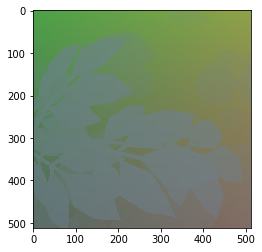

In [19]:
plt.imshow(pic)

In [24]:
# task = "AO", "GI",...
# buffers = a list of "position", "normal", "groundtruth",...
def load_train(task, buffers=None):
    result = {}
    if task == "AO":
        if buffers is None:
            buffers = ["position", "normal", "groundtruth"]
        for buffer_type in buffers:
            result[buffer_type] = load_one_file("./dataset/training_" + buffer_type + ".txt")
    return result

In [28]:
def load_one_file(filename):
    with open(filename) as f:
        images = []
        for line in f.readlines():
            path = line.split()[0]
            images.append(exr_loader(path, ndim=3)) # really 3 ??
    return np.array(images)

In [31]:
data = load_train("AO", ["groundtruth"])

D:\WinPython\python-3.6.5.amd64\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [46]:
%cd D:\Dropbox (GaTech)\CS7643 Deep Learning\DL4CG

D:\Dropbox (GaTech)\CS7643 Deep Learning\DL4CG


In [62]:
import OpenEXR
import Imath

# read image and its dataWindow to obtain its size
pic = OpenEXR.InputFile("./GI/Conference/Normals/000000000..exr")
pic.header()

{'channels': {'A': HALF (1, 1),
  'B': HALF (1, 1),
  'G': HALF (1, 1),
  'R': HALF (1, 1)},
 'compression': NO_COMPRESSION,
 'dataWindow': (0, 0) - (255, 255),
 'displayWindow': (0, 0) - (255, 255),
 'lineOrder': INCREASING_Y,
 'pixelAspectRatio': 1.0,
 'screenWindowCenter': (0.0, 0.0),
 'screenWindowWidth': 1.0}

In [67]:
# read image and its dataWindow to obtain its size
pic = OpenEXR.InputFile("./IBL/Conference/Specular/000000000..exr")
print(pic.header())

pt = Imath.PixelType(Imath.PixelType.FLOAT)
dw = pic.header()['dataWindow']
size = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

pt = Imath.PixelType(Imath.PixelType.FLOAT)

channel = np.fromstring(pic.channel('B', pt), dtype=np.float32)
channel.shape = (size[1], size[0])  # Numpy arrays are (row, col)
np.array(channel)

{'channels': {'A': HALF (1, 1), 'B': HALF (1, 1), 'G': HALF (1, 1), 'R': HALF (1, 1)}, 'compression': NO_COMPRESSION, 'dataWindow': (0, 0) - (255, 255), 'displayWindow': (0, 0) - (255, 255), 'lineOrder': INCREASING_Y, 'pixelAspectRatio': 1.0, 'screenWindowCenter': (0.0, 0.0), 'screenWindowWidth': 1.0}


D:\WinPython\python-3.6.5.amd64\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


array([[0.3046875 , 0.3046875 , 0.3046875 , ..., 0.3046875 , 0.3046875 ,
        0.3046875 ],
       [0.3046875 , 0.3046875 , 0.3046875 , ..., 0.3046875 , 0.3046875 ,
        0.3046875 ],
       [0.3046875 , 0.3046875 , 0.3046875 , ..., 0.3046875 , 0.3046875 ,
        0.3046875 ],
       ...,
       [0.11938477, 0.11938477, 0.11938477, ..., 0.5444336 , 0.5444336 ,
        0.5444336 ],
       [0.11938477, 0.11938477, 0.11938477, ..., 0.5444336 , 0.5444336 ,
        0.5444336 ],
       [0.11938477, 0.11938477, 0.11938477, ..., 0.5444336 , 0.5444336 ,
        0.5444336 ]], dtype=float32)

D:\WinPython\python-3.6.5.amd64\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


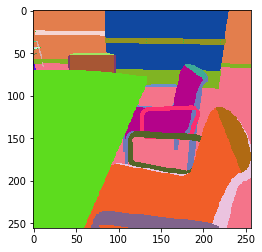

In [70]:
pic = exr_loader("./IBL/Conference/Specular/000000000..exr", ndim=3)
plt.imshow(pic)